In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

import pandas as pd
import yfinance as yf
from statsmodels.stats.stattools import durbin_watson, jarque_bera
from scipy.optimize import minimize

In [5]:
tickers = ['AAPL', 'BAC', 'INTC', 'GME', 'BA', 'BABA', 'UA', 'KO', 'NVDA', 'META']

In [6]:
data = yf.download(tickers, start = '2018-01-01', end = '2021-01-01', group_by = 'ticker', threads = True)

[*********************100%***********************]  10 of 10 completed


In [9]:
data.stack()

C:\Users\dfdop\AppData\Local\Temp\ipykernel_19948\2489631911.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  data.stack()


Ticker                      UA           GME  ...          INTC          META
Date       Price                              ...                            
2018-01-02 Close        13.970  3.988464e+00  ...  3.933038e+01  1.805690e+02
           High         14.010  3.995017e+00  ...  3.937235e+01  1.807282e+02
           Low          13.230  3.883619e+00  ...  3.879310e+01  1.767171e+02
           Open         13.450  3.922936e+00  ...  3.893581e+01  1.768465e+02
           Volume  6264809.000  1.133080e+07  ...  2.337080e+07  1.815190e+07
...                        ...           ...  ...           ...           ...
2020-12-31 Close        14.880  4.710000e+00  ...  4.503854e+01  2.718786e+02
           High         15.113  4.950000e+00  ...  4.537302e+01  2.757902e+02
           Low          14.810  4.700000e+00  ...  4.404411e+01  2.685443e+02
           Open         15.010  4.812500e+00  ...  4.407123e+01  2.707241e+02
           Volume  1981656.000  2.769080e+07  ...  2.857680e+07  1.290040e+07

[3780 rows x 10 columns]

<Axes: xlabel='Date'>

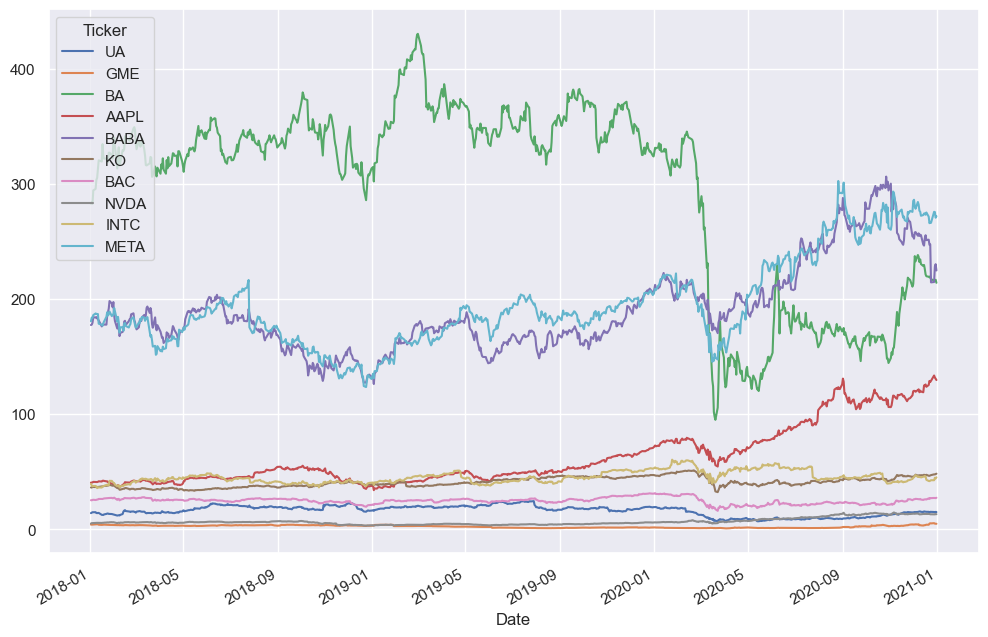

In [13]:
close_prices = data.xs('Close', axis = 1, level = 1)
close_prices.plot(kind = 'line', figsize = (12, 8))

<Axes: xlabel='Date'>

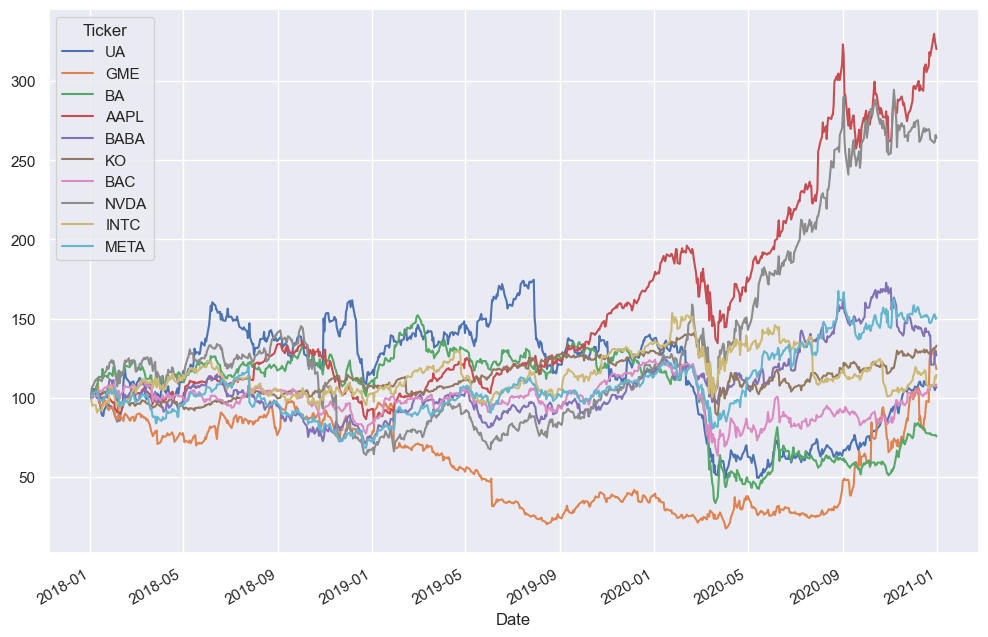

In [16]:
normalize_prices = close_prices.div(close_prices.iloc[0]).mul(100)
normalize_prices.plot(kind = 'line', figsize = (12, 8))

In [17]:
simple_retunrs = close_prices.pct_change().dropna()

<Axes: xlabel='Date'>

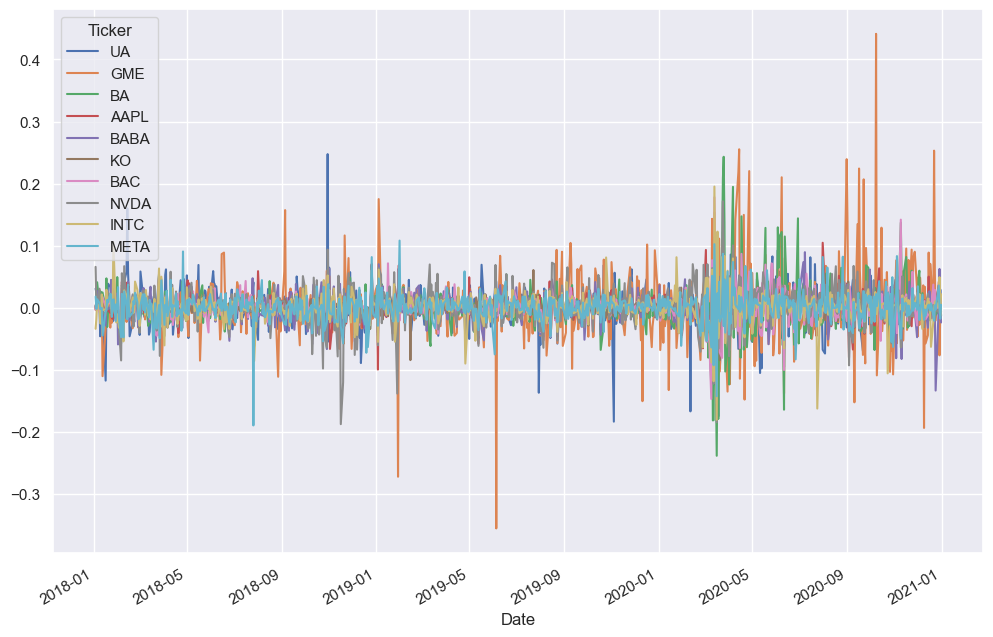

In [19]:
simple_retunrs.plot(kind = 'line', figsize = (12, 8))

In [25]:
daily_returns = simple_retunrs.mean()
daily_risk = simple_retunrs.std()

In [26]:
yearly_returns = daily_returns.apply(lambda x : (1 + x)**252 - 1)
yearly_risk = daily_risk.apply(lambda x : x * np.sqrt(252))

In [38]:
return_risk = pd.concat([yearly_returns, yearly_risk], axis=1)
return_risk.columns = ['yearly_returns', 'yearly_risk']

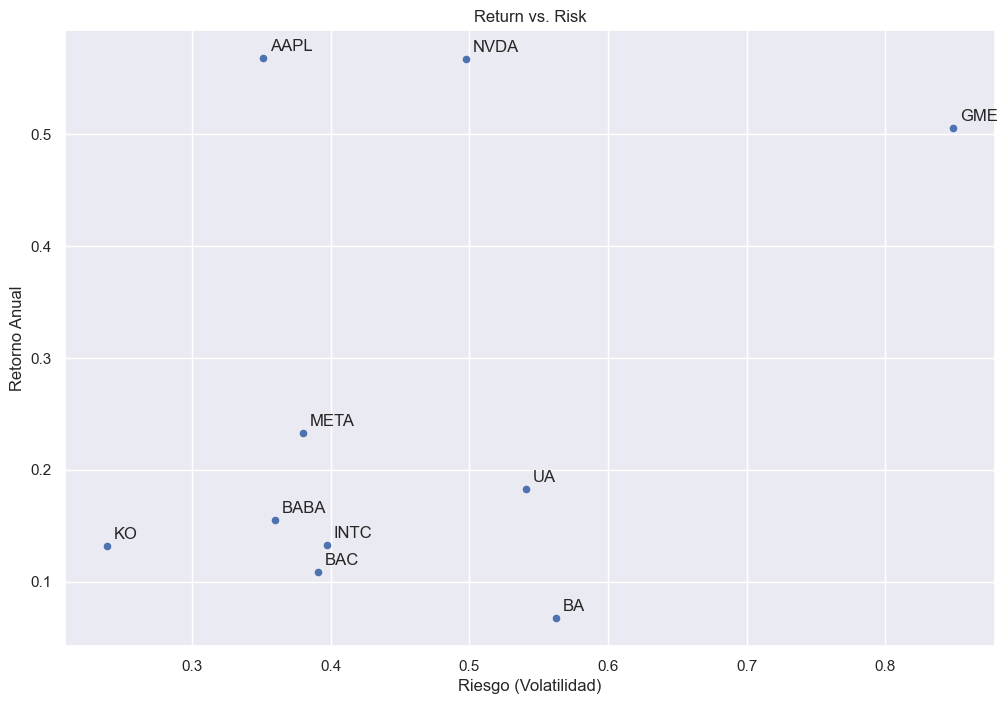

In [45]:
ax = return_risk.plot(
    kind = 'scatter',
    x = 'yearly_risk',
    y = 'yearly_returns',
    figsize = (12, 8),
    title = 'Return vs. Risk'
)

for ticker, row in return_risk.iterrows():
    ax.annotate(
        ticker,
        (row['yearly_risk'], row['yearly_returns']),
        xytext = (5, 5),
        textcoords = 'offset points'
    )
plt.xlabel('Riesgo (Volatilidad)')
plt.ylabel('Retorno Anual')
plt.show()

Calculando la frontera eficiente por medio de simulacion

In [66]:
cov_matrix = simple_retunrs.cov().to_numpy()
exp_returns = yearly_returns.to_numpy()

n_portfolios = 1000000
results = np.zeros((3, n_portfolios))
weights_record = []

for i in range(n_portfolios):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)
    weights_record.append(weights)

    port_return = np.dot(weights, exp_returns)
    port_std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    results[0, i] = port_std
    results[1, i] = port_return
    # Compute Sharp Ratio with a free risk iquals zero
    results[2, i] = port_return / port_std


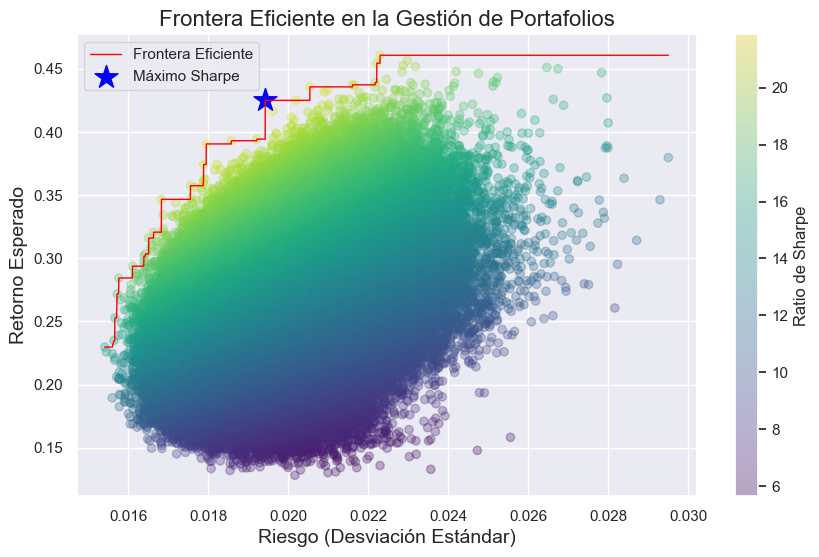

In [68]:
max_sharpe_idx = np.argmax(results[2])
max_sharpe_std = results[0, max_sharpe_idx]
max_sharpe_ret = results[1, max_sharpe_idx]
max_sharpe_weights = weights_record[max_sharpe_idx]

# Ordenar portafolios por riesgo para calcular la frontera eficiente
sorted_indices = np.argsort(results[0])
sorted_risks = results[0, sorted_indices]
sorted_returns = results[1, sorted_indices]

# Calcular el máximo acumulado de retornos, que aproxima la frontera eficiente
efficient_returns = np.maximum.accumulate(sorted_returns)

# Crear el gráfico
plt.figure(figsize=(10, 6))
sc = plt.scatter(results[0], results[1], c=results[2], cmap='viridis', alpha=0.3)
plt.plot(sorted_risks, efficient_returns, color='red', linewidth=1, label='Frontera Eficiente')
plt.scatter(max_sharpe_std, max_sharpe_ret, color='blue', marker='*', s=300, label='Máximo Sharpe')
plt.title('Frontera Eficiente en la Gestión de Portafolios', fontsize=16)
plt.xlabel('Riesgo (Desviación Estándar)', fontsize=14)
plt.ylabel('Retorno Esperado', fontsize=14)
plt.colorbar(sc, label='Ratio de Sharpe')
plt.legend()
plt.grid(True)
plt.show()

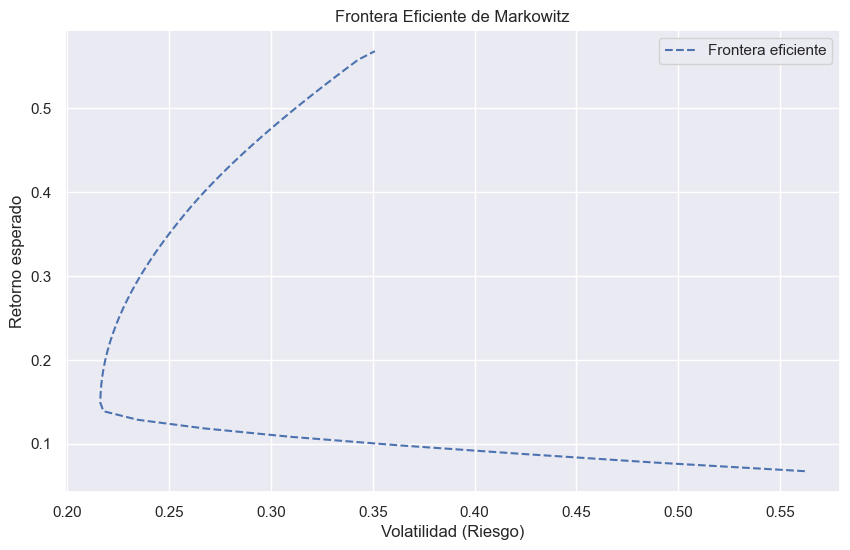

In [67]:
# Función para calcular el rendimiento y volatilidad de la cartera
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, vol

# Función objetivo: minimizar la volatilidad
def minimize_volatility(weights, mean_returns, cov_matrix):
    return portfolio_performance(weights, mean_returns, cov_matrix)[1]

# Función para calcular la frontera eficiente
def calculate_efficient_frontier(mean_returns, cov_matrix, target_returns):
    num_assets = len(mean_returns)
    results = []
    bounds = tuple((0, 1) for _ in range(num_assets))
    # Restricción: la suma de los pesos es 1
    constraints = [{'type': 'eq', 'fun': lambda x: np.sum(x) - 1}]
    
    for target in target_returns:
        # Añadir restricción de retorno
        constraints_target = constraints + [{'type': 'eq', 'fun': lambda x, target=target: np.dot(x, mean_returns) - target}]
        # Valor inicial: pesos iguales
        init_guess = num_assets * [1. / num_assets]
        opt = minimize(minimize_volatility, init_guess,
                       args=(mean_returns, cov_matrix),
                       method='SLSQP', bounds=bounds, constraints=constraints_target)
        if opt.success:
            ret, vol = portfolio_performance(opt.x, mean_returns, cov_matrix)
            results.append((vol, ret, opt.x))
        else:
            results.append((None, None, None))
    return results


mean_returns = exp_returns
cov_matrix = cov_matrix * 252

# Definimos un rango de retornos objetivo
min_return = mean_returns.min()
max_return = mean_returns.max()
target_returns = np.linspace(min_return, max_return, 50)

frontier = calculate_efficient_frontier(mean_returns, cov_matrix, target_returns)

# Extraer volatilidades y retornos de la frontera
vols = [point[0] for point in frontier if point[0] is not None]
rets = [point[1] for point in frontier if point[1] is not None]

# Graficar la frontera eficiente
plt.figure(figsize=(10, 6))
plt.plot(vols, rets, 'b--', label='Frontera eficiente')
plt.xlabel('Volatilidad (Riesgo)')
plt.ylabel('Retorno esperado')
plt.title('Frontera Eficiente de Markowitz')
plt.legend()
plt.show()
